In [1]:
import os
from PIL import Image

import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras

from graphing import *
from file_related import *
from inits import *
from trainers import *
SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
VALID_IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"] # valid extensions

def load_image(infilename):
    img = Image.open(infilename)
    img = img.resize((80,80))
    data = np.asarray(img)
    return data


    
def save_image(np_array, output_filename) :
    im = Image.fromarray(np_array, "RGB")
    im.save(output_filename)     
    
def map_images(data_dir, verbose = False):
    files = {}
    CLASSES = {}

    for class_id, class_dir in enumerate(os.listdir(data_dir)):
        class_name = class_dir
        class_dir = os.path.join(data_dir, class_dir)
        files[class_id] = []
        CLASSES[class_id] = class_name
        for file in os.listdir(class_dir):

            ext = os.path.splitext(file)[1]
            if ext in VALID_IMAGE_EXTENSIONS:

                np_im = load_image(os.path.join(class_dir,file))
                files[class_id].append(np_im)
#                 save_image(np_im,"i.jpg")
        if verbose:
            print(f"Done: {class_dir}")
    return CLASSES, files

# https://www.kaggle.com/prasunroy/natural-images
data_dir = "../testing/data/natural_images/"

CLASSES, files = map_images(data_dir)

In [3]:
def init_users_image(files,  averaging_metric="accuracy", test_size = 0.2, val_size = 0.2, shape=(80,80,3), seed=None):
    users = {}
    keys = list(files.keys())
    
    # initialise users
    for class_id in keys:
        model = init_conv_model(keys, shape, seed)
#         model = init_model()

        option = np.random.RandomState(seed).randint(0,len(averaging_methods))
        users[class_id] = User(user_id=class_id,
                  model = model,
                  averaging_method = averaging_methods[option],
                  averaging_metric = averaging_metric,
                  train_class = None,
                  train_data = None,
                  val_class = None,
                  val_data = None, 
                  test_class = None,
                  test_data = None)
    
    # for class ids in keys, we will now create a majority and rest (of the data) split
    
    for class_id in keys:
        images = np.asarray(files[class_id]).astype("float32")
        # shuffle first pls
        majority_data, rest_data = np.split(images, [int(0.7 * len(images))])
        rest_data_split = np.array_split(rest_data,len(keys)-1)  
        
        rest_data_index = 0
        for user_id in keys:
            if user_id == class_id:
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(majority_data, class_id, test_size, val_size)
            else:
                raw_data = rest_data_split[rest_data_index]
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(raw_data, class_id, test_size, val_size)
                rest_data_index += 1
                
            if class_id == 0:
                users[user_id].set_test_class(test_class)
                users[user_id].set_test_data(test_data)
                users[user_id].set_val_data(val_data)
                users[user_id].set_val_class(val_class)
                users[user_id].set_train_data(train_data)
                users[user_id].set_train_class(train_class)
            else:
                users[user_id].add_test_class(test_class)
                users[user_id].add_test_data(test_data)
                users[user_id].add_val_data(val_data)
                users[user_id].add_val_class(val_class)
                users[user_id].add_train_data(train_data)
                users[user_id].add_train_class(train_class)
    return users

def train_test_val_split(np_data, class_id, test_size, val_size):
    test_data, train_data = np.split(np_data, [int(test_size * len(np_data))])
    val_size = val_size/(1-test_size)
    val_data, test_data = np.split(test_data, [int(val_size * len(test_data))])
    
    train_class = np.full((train_data.shape[0]),class_id)
    test_class = np.full((test_data.shape[0]),class_id)
    val_class = np.full((val_data.shape[0]),class_id)
#     print(f"              {val_class.shape[0] == val_data.shape[0]}")
    return train_data, train_class, test_data, test_class, val_data, val_class
        
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]
      

#     global_user = User()

In [4]:
def train(model, toy=False):
        """
        Train the model
        """
        if toy:
            epochs=3
            steps_per_epoch=20
            validation_steps=2
        else:
            epochs=30
#             steps_per_epoch=100
            steps_per_epoch=30
#             steps_per_epoch=10
            validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_acc'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
        # Train
        training = model.fit(x_train, y_train
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=(x_val, y_val)
                                ,validation_steps=validation_steps
                                ,callbacks=[earlystopper, checkpointer, reduce_lr], verbose=3)
        # Get the best saved weights
        model.load_weights('best_model1.h5')
        return training

In [5]:
DEVICE = '/gpu:0'
ROUNDS = 32 # after about 30-40, it seems to settle down with epochs being 16
EPOCHS = 16

In [6]:
# forces tensorfor to the a particular device to run things
#      # return a dictionary of users with data
users_all = init_users_image(files, seed = SEED)
train_fed(users = users_all, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.all,
          averaging_post = True,
          averaging_metric = "accuracy")

    # return a dictionary of users with data
#     users_all_2, global_user = init_users(df = df, 
#                                         averaging_methods = averaging_methods, 
#                                         seed = SEED)
#     train_fed(users = users_all_2, rounds = ROUNDS,
#               epochs = EPOCHS,
              
#               strat = "personalised",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_post = True,
#               averaging_metric = "accuracy")
    
#      print(len(users_all[2].get_history_metrics()["sparse_categorical_accuracy"]))
#     draw_graphs(users_all[2])   

********************************  0   ********************************
0 [28.319785854680752, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.136819319291547, 0.015151516]
******************************** DONE ********************************
********************************  1   ********************************
0 [1.4362894432331488, 0.6097561]
1 [1.7917893138425103, 0.5086207]
2 [1.8314796388149261, 0.3203125]
3 [1.5611462728351566, 0.5319149]
4 [1.896039644877116, 0.28070176]
5 [1.10775359471639, 0.7847222]
6 [1.4093041069857724, 0.67132866]
7 [1.889892375830448, 0.36363637]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.620489666132423, 0.80487806]
1 [1.2526198420031318, 0.6896552]
2 [1.7830768525600433, 0.507

All
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.813481
Standard Deviation    0.133746
Minimum               0.561404
Maximum                 0.9375
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.853699
Standard Deviation    0.0801669
Minimum                0.710526
Maximum                  0.9375
Name: 63, dtype: object



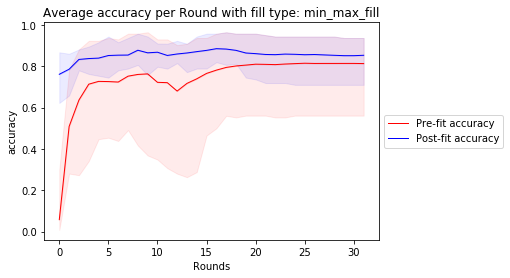

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.918699
3     1     0.862069
5     2     0.796875
7     3     0.879433
9     4     0.561404
11    5     0.937500
13    6     0.923077
15    7     0.628788
Averaged: 0.8134805113077164

Final accuracy for Post-fit data
   User  Final Value
0     0     0.926829
2     1     0.862069
4     2     0.789062
6     3     0.907801
8     4     0.710526
10    5     0.937500
12    6     0.923077
14    7     0.772727
Averaged: 0.8536990731954575



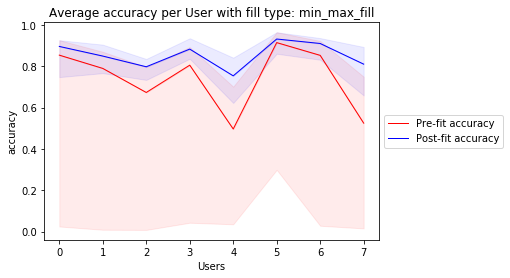

<Figure size 432x288 with 0 Axes>

In [7]:
ignore_first_n = 0
final_values = True

GRAPHING_METRIC = "accuracy"


print("All")

# print("For p2p")


# df_avg_round_stats_acc = avg_round_stats(users_all_2, 
#                                          ignore_first_n = ignore_first_n, 
#                                          min_max_fill = True, 
#                                          metric = "accuracy",
#                                          final_values = final_values)
# df_avg_user_stats_acc = avg_user_stats(users_all_2, 
#                                        ignore_first_n = ignore_first_n, 
#                                        min_max_fill = True, 
#                                        metric = "accuracy",
#                                        final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)

In [8]:
averaging_methods = [Average.std_dev]
# return a dictionary of users with data
users_std_dev = init_users_image(files, seed = SEED)
train_fed(users = users_std_dev, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method =  Average.std_dev,
         averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_std_dev_2 = init_users_image(files, seed = SEED)
train_fed(users = users_std_dev_2, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")



********************************  0   ********************************
0 [28.319785854680752, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.136819319291547, 0.015151516]
User 7: 0.6666666865348816 < 0.7134227175457541
******************************** DONE ********************************
********************************  1   ********************************
0 [1.1716074342650127, 0.6585366]
1 [1.695407431701134, 0.54310346]
2 [1.761806845664978, 0.3046875]
3 [1.505396068518889, 0.5460993]
4 [1.8487389882405598, 0.28947368]
5 [0.7383520205815634, 0.8125]
6 [1.2350472628653466, 0.7062937]
7 [1.8546369364767363, 0.3409091]
User 7: 0.6439393758773804 < 0.7361281050024362
******************************** DONE ********************************
********************************  2   ********************************
0 [

Std deviation
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.801443
Standard Deviation    0.181587
Minimum               0.359649
Maximum               0.965278
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.881771
Standard Deviation    0.0489862
Minimum                0.798246
Maximum                0.965278
Name: 63, dtype: object



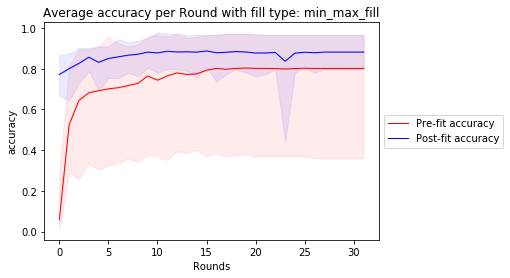

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.894309
3     1     0.887931
5     2     0.789062
7     3     0.886525
9     4     0.359649
11    5     0.965278
13    6     0.909091
15    7     0.719697
Averaged: 0.8014427646994591

Final accuracy for Post-fit data
   User  Final Value
0     0     0.894309
2     1     0.887931
4     2     0.835938
6     3     0.914894
8     4     0.798246
10    5     0.965278
12    6     0.909091
14    7     0.848485
Averaged: 0.8817712888121605



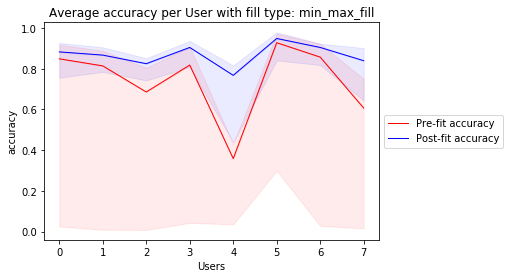

For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.823873
Standard Deviation    0.137699
Minimum               0.552632
Maximum               0.958333
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                  0.8787
Standard Deviation    0.0857205
Minimum                0.692982
Maximum                0.958333
Name: 63, dtype: object



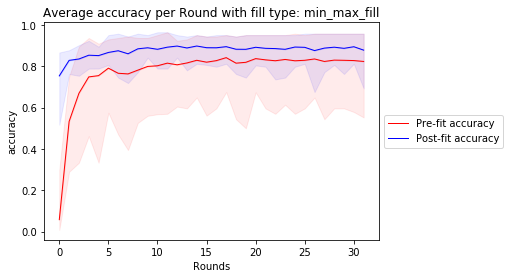

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.918699
3     1     0.879310
5     2     0.710938
7     3     0.914894
9     4     0.552632
11    5     0.958333
13    6     0.944056
15    7     0.712121
Averaged: 0.823872834444046

Final accuracy for Post-fit data
   User  Final Value
0     0     0.934959
2     1     0.887931
4     2     0.812500
6     3     0.950355
8     4     0.692982
10    5     0.958333
12    6     0.944056
14    7     0.848485
Averaged: 0.8787001967430115



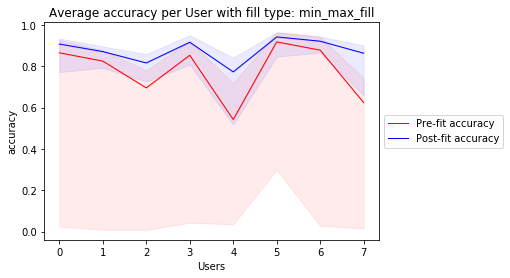

<Figure size 432x288 with 0 Axes>

In [9]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Std deviation")
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)
print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_std_dev_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)


# print(users_std_dev[1].get_history_metrics())


In [10]:
averaging_methods = [Average.weighted_avg]

# return a dictionary of users with data
users_weighted_avg = init_users_image(files, seed = SEED)
train_fed(users = users_weighted_avg, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.weighted_avg,
          averaging_post = True,
          averaging_metric = "accuracy")

# return a dictionary of users with data
users_weighted_avg_2 = init_users_image(files, seed = SEED)
train_fed(users = users_weighted_avg_2, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "personalised",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")

********************************  0   ********************************
0 [28.319785854680752, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.136819319291547, 0.015151516]
******************************** DONE ********************************
********************************  1   ********************************
0 [1.5430593829814012, 0.6178862]
1 [1.7935773833044644, 0.4827586]
2 [1.8323272466659546, 0.3125]
3 [1.611892615649717, 0.5531915]
4 [1.920994890363593, 0.2631579]
5 [1.3189139366149902, 0.7361111]
6 [1.377671324289762, 0.73426574]
7 [1.9073862740487764, 0.38636363]
******************************** DONE ********************************
********************************  2   ********************************
0 [0.580046022810587, 0.8292683]
1 [1.3215320644707516, 0.7155172]
2 [1.475721299648285, 0.6015625]

Weighted average
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.822026
Standard Deviation    0.133482
Minimum               0.587719
Maximum               0.965278
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.871613
Standard Deviation    0.0816253
Minimum                0.710526
Maximum                0.965278
Name: 63, dtype: object



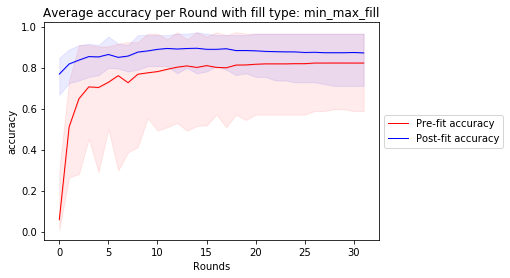

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.918699
3     1     0.870690
5     2     0.781250
7     3     0.900709
9     4     0.587719
11    5     0.965278
13    6     0.923077
15    7     0.628788
Averaged: 0.8220262452960014

Final accuracy for Post-fit data
   User  Final Value
0     0     0.934959
2     1     0.879310
4     2     0.828125
6     3     0.936170
8     4     0.710526
10    5     0.965278
12    6     0.923077
14    7     0.795455
Averaged: 0.8716125637292862



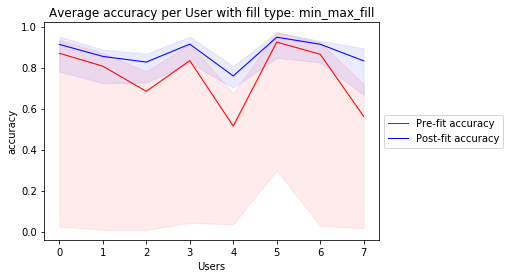

For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                       31
Average               0.793791
Standard Deviation    0.141553
Minimum               0.535088
Maximum               0.958333
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                0.862765
Standard Deviation    0.0575752
Minimum                0.789474
Maximum                0.958333
Name: 63, dtype: object



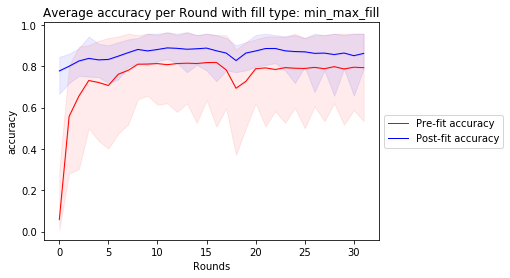

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.910569
3     1     0.853448
5     2     0.710938
7     3     0.851064
9     4     0.535088
11    5     0.958333
13    6     0.902098
15    7     0.628788
Averaged: 0.793790690600872

Final accuracy for Post-fit data
   User  Final Value
0     0     0.910569
2     1     0.862069
4     2     0.804688
6     3     0.879433
8     4     0.789474
10    5     0.958333
12    6     0.902098
14    7     0.795455
Averaged: 0.8627647086977959



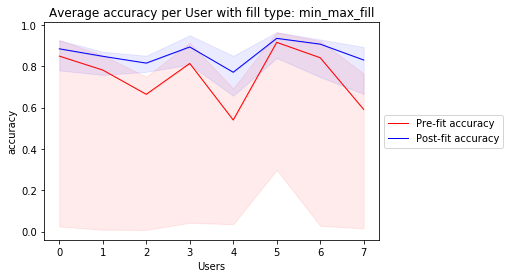

<Figure size 432x288 with 0 Axes>

In [11]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"

print("Weighted average")

print("For central")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)


In [12]:
users_local_only = init_users_image(files, seed = SEED)
train_fed(users = users_local_only, rounds = ROUNDS,
          epochs = EPOCHS,

          strat = "local_trainings_only",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_post = True,
          averaging_metric = "accuracy")
        
#     print("Global user training and validation")

#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = False,
#        verbose_evaluate = False,
#     )

********************************  0   ********************************
0 [28.319785854680752, 0.024390243]
1 [29.658505801496833, 0.00862069]
2 [36.57966995239258, 0.0078125]
3 [17.63535905391612, 0.04255319]
4 [19.69100985610694, 0.03508772]
5 [11.995550473531088, 0.2986111]
6 [18.299281780536358, 0.027972028]
7 [28.136819319291547, 0.015151516]
******************************** DONE ********************************
********************************  1   ********************************
0 [0.9855211517675136, 0.7479675]
1 [1.2853528302291344, 0.79310346]
2 [1.8857584558427334, 0.734375]
3 [0.8045492899333332, 0.83687943]
4 [3.6837716353567025, 0.7017544]
5 [0.7932616612977199, 0.8611111]
6 [0.7523559357944902, 0.85314685]
7 [1.5789281563325361, 0.65909094]
******************************** DONE ********************************
********************************  2   ********************************
0 [1.9227649237036826, 0.7886179]
1 [1.5684680065204357, 0.86206895]
2 [2.4238103123434485, 

Local training only
Final values for Pre-fit accuracy
Position                    Pre
Round                        31
Average                 0.81459
Standard Deviation    0.0564468
Minimum                0.701754
Maximum                0.881944
Name: 62, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        31
Average                 0.81459
Standard Deviation    0.0564468
Minimum                0.701754
Maximum                0.881944
Name: 63, dtype: object



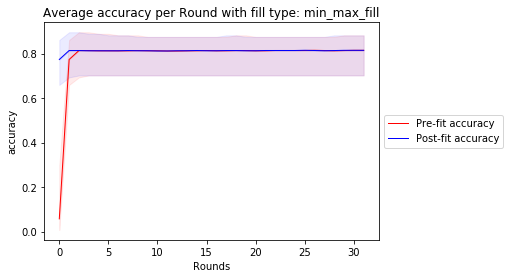

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.772358
3     1     0.870690
5     2     0.804688
7     3     0.822695
9     4     0.701754
11    5     0.881944
13    6     0.867133
15    7     0.795455
Averaged: 0.8145895078778267

Final accuracy for Post-fit data
   User  Final Value
0     0     0.772358
2     1     0.870690
4     2     0.804688
6     3     0.822695
8     4     0.701754
10    5     0.881944
12    6     0.867133
14    7     0.795455
Averaged: 0.8145895078778267



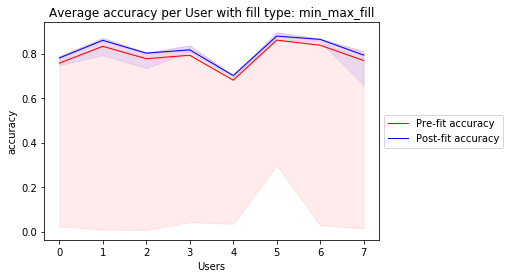

<Figure size 432x288 with 0 Axes>

In [13]:
ignore_first_n = 0
final_values = True
GRAPHING_METRIC = "accuracy"


print("Local training only")


df_avg_round_stats_acc = avg_round_stats(users_local_only, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = GRAPHING_METRIC,
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_local_only, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = GRAPHING_METRIC,
                                       final_values = final_values)
# draw_graphs(users_all_2[2])

# print("Global user")
# draw_graphs(global_user)
# global_user.evaluate(verbose=False)

In [ ]:
for user in users_std_dev_2.values():
    draw_graphs(user)

In [ ]:

for user in users.values():
    